In [9]:
import matplotlib.pyplot as plt
import zipfile
import pandas as pd
import os
import numpy as np


zip_path = "MPA-MLF_DATA_NEW.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")



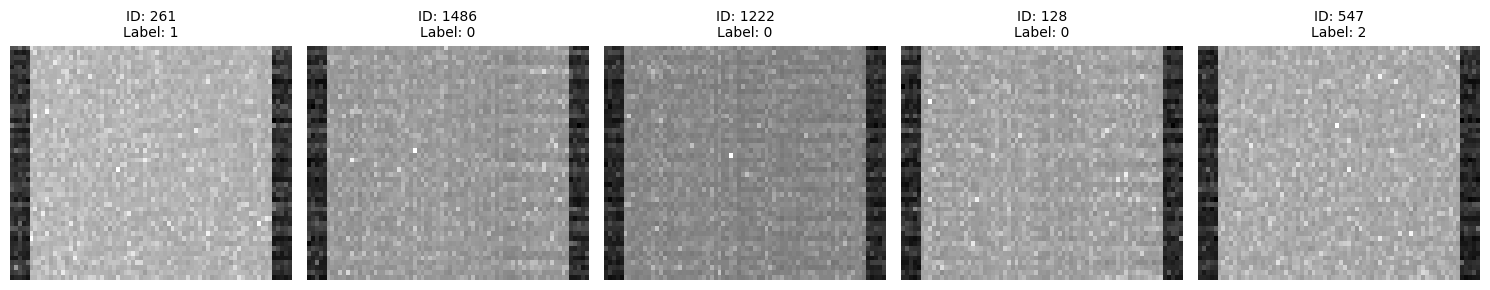

In [10]:
import random
plt.figure(figsize=(15, 3))

train_path = "dataset/Train"
label_df = pd.read_csv("dataset/label_train.csv")

# Get a list of all files in the train_path directory
all_files = os.listdir(train_path)

# Select 5 random files for visualization
random_files = random.sample(all_files, 5)

for i, file in enumerate(random_files):
    data = np.load(os.path.join(train_path, file))


    file_name_without_extension = os.path.splitext(file)[0]
    label = label_df[label_df['ID'] == int(file_name_without_extension)]['target'].values[0]

    plt.subplot(1, 5, i + 1)
    plt.imshow(data.T, cmap='gray', aspect='auto')
    plt.axis('off')

    plt.title(f"ID: {file_name_without_extension}\nLabel: {label}", fontsize=10)

plt.tight_layout()
plt.show()


In [11]:
data.shape

(72, 48)

In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


train_path = "dataset/Train"
label_df = pd.read_csv("dataset/label_train.csv")


files = os.listdir(train_path)


X = []
y = []

for file in files:
    file_path = os.path.join(train_path, file)
    data = np.load(file_path)
    file_id = int(os.path.splitext(file)[0])

    label_row = label_df[label_df['ID'] == file_id]
    if not label_row.empty:
        label = label_row['target'].values[0]
        X.append(data)
        y.append(label)


X = np.array(X)
y = np.array(y)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (1192, 72, 48)
y_train shape: (1192,)
X_val shape: (299, 72, 48)
y_val shape: (299,)


In [13]:
X_train_normalized = X_train.astype('float32') / 255.0  # [0, 1]
X_val_normalized = X_val.astype('float32') / 255.0

In [14]:
X_train_with_channel = X_train_normalized[..., np.newaxis]
X_val_with_channel = X_val_normalized[..., np.newaxis]

In [15]:
X_train_with_channel.shape
X_val_with_channel.shape

(299, 72, 48, 1)

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(72, 48, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 70, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 35, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 33, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       655,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 674,435 (2.57 MB)

 Trainable params: 674,435 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train_with_channel, y_train,
    validation_data=(X_val_with_channel, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.7357 - loss: 0.7317 - val_accuracy: 0.8462 - val_loss: 0.4639
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.8697 - loss: 0.4361 - val_accuracy: 0.8930 - val_loss: 0.3685
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.8931 - loss: 0.3228 - val_accuracy: 0.8963 - val_loss: 0.2721
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9210 - loss: 0.2120 - val_accuracy: 0.9666 - val_loss: 0.1483
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9679 - loss: 0.1018 - val_accuracy: 0.9699 - val_loss: 0.1065
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9831 - loss: 0.0642 - val_accuracy: 0.9833 - val_loss: 0.0913
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.9843 - loss: 0.0468 - val_accuracy: 0.9699 - val_loss: 0.1115
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.9786 - loss: 0.0584 - val_accuracy: 0.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9861 - loss: 0.0413
Accuracy in validation: 0.9833


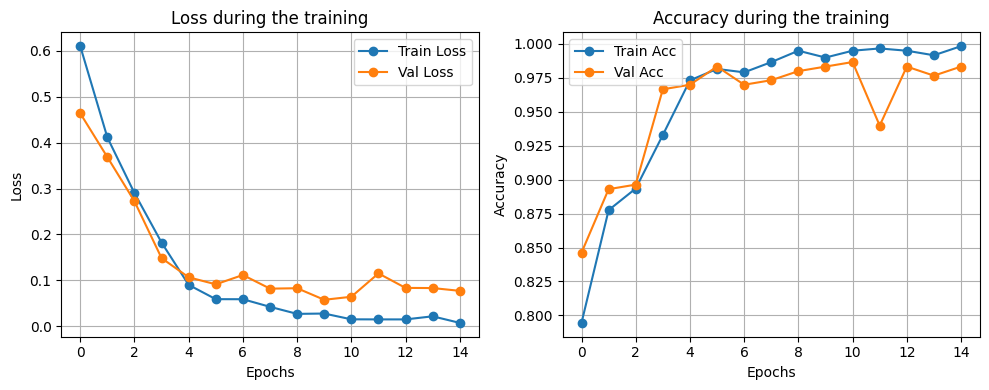

In [18]:
val_loss, val_acc = model.evaluate(X_val_with_channel, y_val)
print(f"Accuracy in validation: {val_acc:.4f}")

import matplotlib.pyplot as plt



# Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss during the training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy during the training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Now with the Test folder

In [19]:

train_path = "dataset/Test"
label_df = pd.read_csv("dataset/test_format.csv")


files = os.listdir(train_path)


X1 = []
y1 = []

for file in files:
    file_path = os.path.join(train_path, file)
    data = np.load(file_path)
    file_id = int(os.path.splitext(file)[0])

    label_row = label_df[label_df['ID'] == file_id]
    if not label_row.empty:
        label = label_row['target'].values[0]
        X1.append(data)
        y1.append(label)


X1 = np.array(X1)
y1 = np.array(y1)


X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)


print("X1_train shape:", X1_train.shape)
print("y1_train shape:", y1_train.shape)
print("X1_val shape:", X1_val.shape)
print("y1_val shape:", y1_val.shape)

X1_train shape: (96, 72, 48)
y1_train shape: (96,)
X1_val shape: (24, 72, 48)
y1_val shape: (24,)


In [21]:
X1_train_normalized = X1_train.astype('float32') / 255.0  # [0, 1]
X1_val_normalized = X1_val.astype('float32') / 255.0

In [22]:
X1_train_with_channel = X1_train_normalized[..., np.newaxis]
X1_val_with_channel = X1_val_normalized[..., np.newaxis]

In [23]:
X1_train_with_channel.shape
X1_val_with_channel.shape

(24, 72, 48, 1)

In [24]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X1_train_with_channel, y1_train,
    validation_data=(X1_val_with_channel, y1_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.5130 - loss: 3.2768 - val_accuracy: 0.7917 - val_loss: 1.0432
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8815 - loss: 0.5603 - val_accuracy: 1.0000 - val_loss: 2.4835e-08
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 1.0000 - loss: 8.0715e-09 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 1.0000 - los

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Accuracy in validation: 1.0000


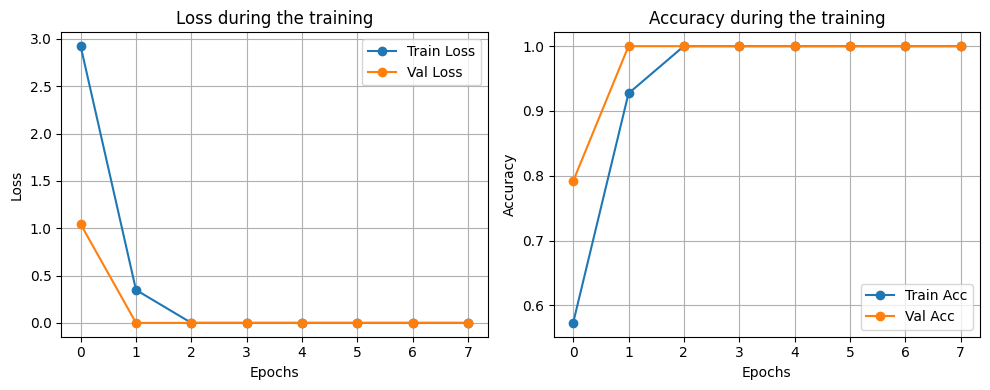

In [25]:
val_loss, val_acc = model.evaluate(X1_val_with_channel, y1_val)
print(f"Accuracy in validation: {val_acc:.4f}")

import matplotlib.pyplot as plt



# Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss during the training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy during the training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
# Preprocess the entire test dataset
X1_normalized = X1.astype('float32') / 255.0  # Normalize
X1_with_channel = X1_normalized[..., np.newaxis]  # Add channel dimension

# Predict on the entire test dataset
predictions = model.predict(X1_with_channel)
predicted_classes = np.argmax(predictions, axis=1)

# Create DataFrame with predictions for all test files
output_df = pd.DataFrame({
    'ID': [int(os.path.splitext(file)[0]) for file in files],  # IDs for all test files
    'target': predicted_classes  # Predictions for all test files
})

# Save to CSV
output_df.to_csv('predictions.csv', index=False)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
